# VAE Image generation

Cassandra Maldonado

In [3]:
%pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
Using cached tensorflow-2.19.0-cp312-cp312-macosx_12_0_arm64.whl (252.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [6]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 160000)    │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │  2,560,016 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,579,476 (9.84 MB)

 Trainable params: 2,579,476 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 * 50 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((50, 50, 128))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320000)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 200, 200, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 200, 200, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,123 (4.02 MB)

 Trainable params: 1,053,123 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### 1. Train VAE. Fit the VAE model using one of the 2 pictures, call it pic_1.

### Trim the picture to fit the input 200-by-200 dimensions using.

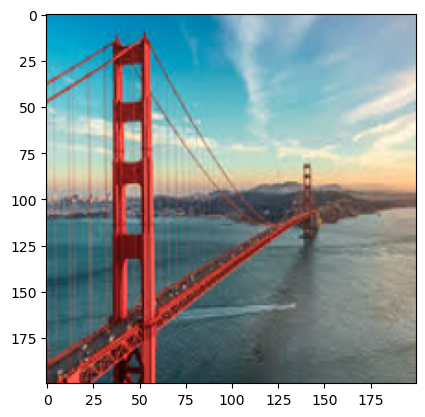

In [9]:
pic_1 = Image.open("pic_1.jpeg").convert("RGB")

pic_1 = pic_1.resize((220, 202))
pic_1 = np.array(pic_1)

pic_1 = np.expand_dims(pic_1, 0).astype("float32") / 255
pic_1 = pic_1[:,-201:-1, 0:200]

plt.imshow(pic_1[0])

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pic_1, epochs=100, batch_size=1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - kl_loss: 0.0502 - loss: 27726.1172 - reconstruction_loss: 27726.0664
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 57.6940 - loss: 27776.8906 - reconstruction_loss: 27719.1973
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - kl_loss: 2.9194 - loss: 27716.9258 - reconstruction_loss: 27714.0059
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 6.9141e-06 - loss: 27706.4805 - reconstruction_loss: 27706.4805
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 1.8775e-06 - loss: 27701.0586 - reconstruction_loss: 27701.0586
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 0.8864 - loss: 27679.7207 - reconstruction_loss: 27678.8340
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 3.1454 - loss: 27678.2227 - reconstruction_loss: 27675.0781
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 6.1361 - loss: 27612.2148 - reconstruction_loss: 27606.0781
Epoch 9/100
1/1 ━━━━━━

### 2. Sample the latent space. Explain the code in the Sampling function (copied below).

In [51]:
z_mean, z_log_var = inputs
batch = tf.shape(z_mean)[0]
dim = tf.shape(z_mean)[1]
epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#Line by line:

NameError: name 'inputs' is not defined

z_mean, z_log_var = inputs

This first line is where I get our two inputs. These are what the encoder network calculates, the z_mean is the mean of the latent distribution and z_log_var is the log of the variance.

batch = tf.shape(z_mean)[0]

dim = tf.shape(z_mean)[1]

Then I'm figuring out the dimensions I'm working with. The batch size is how many samples I'm processing at once and the dimension is how big each latent vector is. I need these to create the random noise with the right shape.

epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

Now I generate this random noise called epsilon from a normal distribution. It's like rolling a bunch of random dice, but they follow that normal distribution pattern.

### 3. Generate Images. Then use the same picture to generate a new copy as follows:

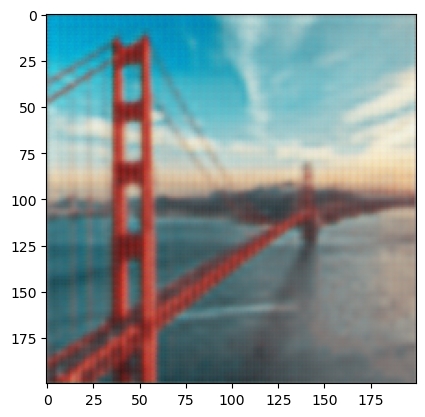

In [11]:
sampling = Sampling()

z_mean, z_log_var, _ = encoder.predict(pic_1, verbose=0)

z_sample = sampling([z_mean, z_log_var])
recon1 = decoder.predict(z_sample, verbose=0)

plt.imshow(recon1[0])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[-3.3571734  1.9505622]] [[-2.9831245  2.1022594]]
[[-3.3989842 -2.7155077]]


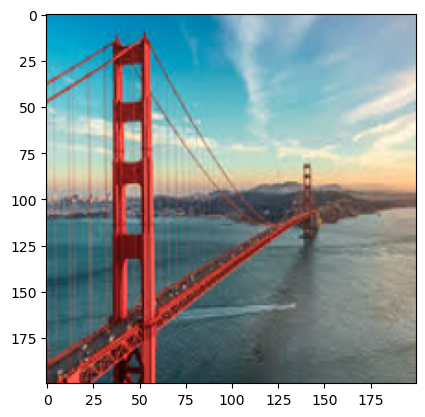

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(1, 200, 200, 3)


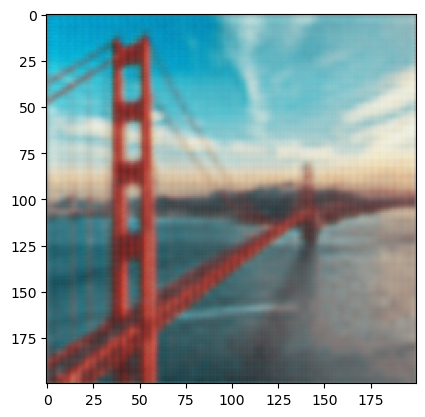

In [13]:
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_1)

print(z_mean, z_log_var)
print(encoded_imgs)

plt.imshow(pic_1[0])
plt.show()

decoded_imgs = decoder.predict(encoded_imgs)
print(decoded_imgs.shape)
plt.imshow(decoded_imgs[0])
plt.show()


### 4. New input data. Rerun the generate copy code with the other picture, call it pic_2.

### What output do you see? Explain why.

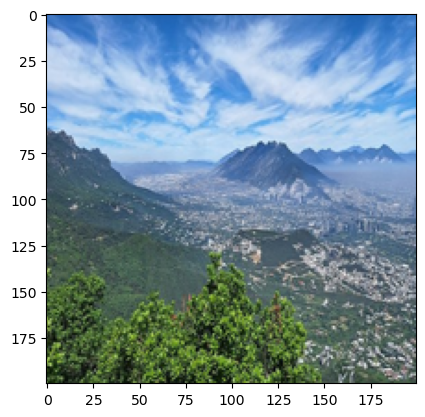

In [18]:
pic_2 = Image.open("pic_2.jpeg").convert("RGB")

pic_2 = pic_2.resize((220, 202))
pic_2 = np.array(pic_2)

pic_2 = np.expand_dims(pic_2, 0).astype("float32") / 255
pic_2 = pic_2[:,-201:-1, 0:200]

plt.imshow(pic_2[0])

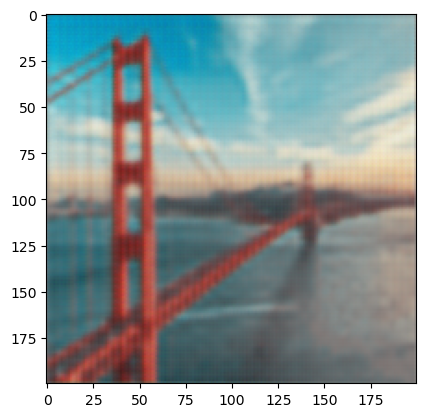

In [19]:
sampling = Sampling()

z_mean, z_log_var, _ = encoder.predict(pic_2, verbose=0)

z_sample = sampling([z_mean, z_log_var])
recon1 = decoder.predict(z_sample, verbose=0)

plt.imshow(recon1[0])
plt.show()

###......This is the same image as pic_1. This makes sense, since the model was never trained to do anything other than reconstruct pic_1. So, it can't reconstruct pic_2, since that is out of distribution.